<a href="https://colab.research.google.com/github/huytranvan2010/huytranvan2010.github.io/blob/main/Denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

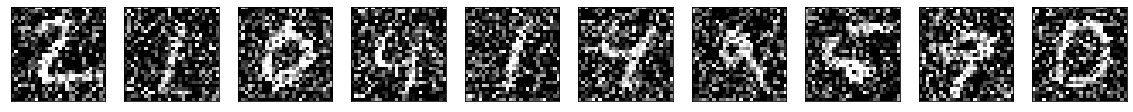

In [16]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers

(x_train, _), (x_test, _) = mnist.load_data()

# normalize và reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add noise vào ảnh
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)   # size đúng với x_train để kớp
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# clip, giá trị nào lớn hơn 1 cho về 1, nhỏ hơn 0 cho về 0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# hiển thị một số ảnh
n = 10
plt.figure(figsize=(20,2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))     # ảnh bị normalize về [0, 1] mà vẫn hiển thị nhỉ
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [17]:
# Xay dung model
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)
# Decoder y hệt như encoder nhưng theo hướng ngược lại
# Có thể dùng Conv2DTranspose hoặc Upsampling2D

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 32)        0   

In [49]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

hist = autoencoder.fit(x_train_noisy, x_train,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0953 - val_loss: 0.0949
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0952 - val_loss: 0.0954
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0951 - val_loss: 0.0947
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0950 - val_loss: 0.0947
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0949 - val_loss: 0.0945
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0948 - val_loss: 0.0945
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0947 - val_loss: 0.0943
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0945 - val_loss: 0.0944
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0945 - val_loss: 0.0942
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0944 - val_loss: 0.0940

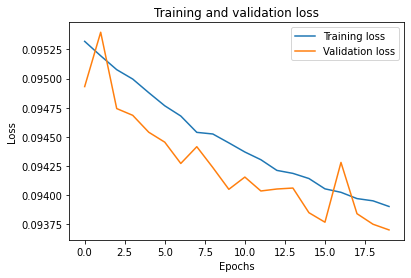

In [50]:
# funstion for train and val losses visualizations
def plot_losses(hist):
    plt.plot(np.arange(NUM_EPOCHS), hist.history['loss'], label='Training loss')
    plt.plot(np.arange(NUM_EPOCHS), hist.history['val_loss'],label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

# visualize train and val losses
plot_losses(hist)


## Kiểm tra lại

(1, 28, 28, 1)


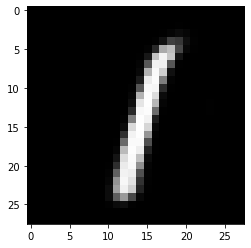

In [51]:
import numpy as np

img = x_test_noisy[5]
img = img[np.newaxis, ...]      # đúng shape(1, 28, 28, 1)

print(img.shape)
new_img = autoencoder.predict(img)

# post processing
new_img = new_img * 255
new_img = new_img.astype("uint8")   # trả về unsigned integer

plt.imshow(new_img.reshape(28, 28))     # reshape lại. Cái này để chính xác nên dùng tf.squeeze để dropout các axis cho chính xác
plt.show()